<img src = './logo.png'>

* ref: https://dacon.io/competitions/official/235680/overview/description

# Competetion Description

##. 평가
KOSPI-200과 KOSDAQ-150의 주어진 기간 중 마지막으로 거래된 가격(종가) 예측

평가 산식: NMAE * 100

평가 (Public, Private score)
public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
private score: 11월 29일 ~ 12월 3일 주식 종료 예측값


## Feature
1.stock_list.csv : 종목 번호 데이터

종목명 : 주식 종목 명
종목코드 : 주식 종목 코드번호
상장시장 : 주식 종목 상장 시장 (KOSPI or KOSDAQ)
 

2.sample_submission.csv

sample_submission 데이터

sample_submission.shape : (10, 371)

# 0. Import

In [ ]:
# 
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# warning
import warnings
warnings.filterwarnings(action='ignore')

# re
import re

# os
import os
import shutil # shutil.rmtree

# datetime
import datetime as dt 
from dateutil.rrule import rrule, YEARLY, MONTHLY, WEEKLY

# visualization
import matplotlib.pyplot as plt
plt.rc('font', family='Gothic') # For Windows. PLOT에서 한글 처리 -> 플롯 만드는 창에 넣어야 됨.

plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # - 기호 안 깨지게
plt.rcParams['font.size'] = 15

from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

%matplotlib inline 

# plt.figure(figsize=(12,4)) # plot 12:4 비율

import seaborn as sns
sns.set() # seaborn에서 회색 grid 깔아줌
sns.set(rc={'figure.figsize':(18, 5)}) # 결과 plot 크기 키워줌


In [ ]:
# 사이킷런
from sklearn.model_selection import train_test_split

# 사이킷런 분류
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC

# 사이킷런 분류 점수
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# 						 # ---> y_true, y_pred
# from sklearn.metrics import precision_recall_curve # y_true, probas_pred
# from sklearn.metrics import roc_auc_score, roc_curve # y_true, y_score

# 분류 ensemble
# import xgboost as xgb
# from xgboost import plot_importance 
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier # lgb.쓰기 귀찮으니까 Classifier까지 import
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
# sklearn regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.svm import SVC #linear SVC는 classifier 성 / SVC는 분류말고 회귀에도 쓸 수 있다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score # squared=False로 하면 RMSE

In [ ]:
# sklearn scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# sklearn augmentation
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

In [ ]:
# ------------- tensorflow & keras -----------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
from keras.layers import LSTM                              #-------------RNN
from keras.preprocessing.image import ImageDataGenerator   #-------------Augmentation
from keras.preprocessing.image import array_to_img, img_to_array, load_img # ㄴ flow



from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

# --------------------- etc. -----------------------
from PIL import Image

# ----------------- fixing seed --------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [ ]:
! pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Data Load

## 1.1 load

In [ ]:
# colab
# load train & submission data
stock_list = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/stock_list.csv')
sub = pd.read_csv('/content/gdrive/MyDrive/stock_price_d/dataset/sample_submission (1).csv')

## 1.2 shape

In [ ]:
stock_list.shape, sub.shape

((370, 3), (10, 371))

## 1.3 info

In [ ]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     370 non-null    object
 1   종목코드    370 non-null    int64 
 2   상장시장    370 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 371 entries, Day to 950130
dtypes: int64(370), object(1)
memory usage: 29.1+ KB


## 1.4 head

In [ ]:
stock_list.head(3)

,종목명,종목코드,상장시장,industry,main_product,listed_date,settle_month,hpage,상장일,증권구분,주식종류,액면가,상장주식수
0,삼성전자,005930,KOSPI,통신 및 방송 장비 제조업,"IMT2000 서비스용 동기식 기지국,교환국장비,데이터단말기,동영상휴대폰,핵심칩,반...",1975-06-11,12월,http://www.sec.co.kr,1975-06-11,주권,보통주,100,5.969783e+09
1,SK하이닉스,000660,KOSPI,반도체 제조업,"반도체,컴퓨터,통신기기 제조,도매",1996-12-26,12월,http://www.skhynix.com,1996-12-26,주권,보통주,5000,7.280024e+08
2,NAVER,035420,KOSPI,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업",포털 서비스 및 온라인 광고,2008-11-28,12월,http://www.navercorp.com,2008-11-28,주권,보통주,100,1.640491e+08


In [ ]:
sub.head(3)

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.6 load other data

### 1.6.2 Stock price

In [ ]:
# start_date = '20210101'
# end_date = '20201231'


# for code in stock_list['종목코드'][:10]:
#     globals()[f'stock_{code}'] = fdr.DataReader(code, start = start_date, end = end_date)


# for code in stock_list['종목코드'][:10]:
#     globals()[f'stock_{code}'] = fdr.DataReader(code, start = start_date, end = end_date)

KeyboardInterrupt: ignored

# 2. Predicting Sample stock price

## 2.1 Picking Sample

In [ ]:
sample_p = '006400'
sample_q = '035760'

In [ ]:
stock_list[(stock_list['종목코드']==sample_p) | (stock_list['종목코드']==sample_q)]

,종목명,종목코드,상장시장,industry,main_product,listed_date,settle_month,hpage,상장일,증권구분,주식종류,액면가,상장주식수
7,삼성SDI,006400,KOSPI,일차전지 및 축전지 제조업,"2차전지, 전자재료 제조 판매",1979-02-27,12월,http://www.samsungsdi.co.kr,1979-02-27,주권,보통주,5000,68764530.0
193,CJ ENM,035760,KOSDAQ,텔레비전 방송업,"의류, 생활주방, 가전제품, 보석, 기타",1999-11-23,12월,http://www.cjmall.com,1999-11-23,주권,보통주,5000,21929154.0


In [ ]:
start_date = '19900101'
end_date = '20211215'
name_list = ['p', 'q']
i=0

for code in (sample_p, sample_q): 
    globals()[f'stock_{name_list[i]}'] = fdr.DataReader(code, start = start_date, end = end_date)
    i+=1

In [ ]:
stock_q.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5447 entries, 1999-11-23 to 2021-12-15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5447 non-null   int64  
 1   High    5447 non-null   int64  
 2   Low     5447 non-null   int64  
 3   Close   5447 non-null   int64  
 4   Volume  5447 non-null   int64  
 5   Change  5446 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 297.9 KB


In [ ]:
stock_p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5946 entries, 1998-01-22 to 2021-12-15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5946 non-null   int64  
 1   High    5946 non-null   int64  
 2   Low     5946 non-null   int64  
 3   Close   5946 non-null   int64  
 4   Volume  5946 non-null   int64  
 5   Change  5945 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 325.2 KB


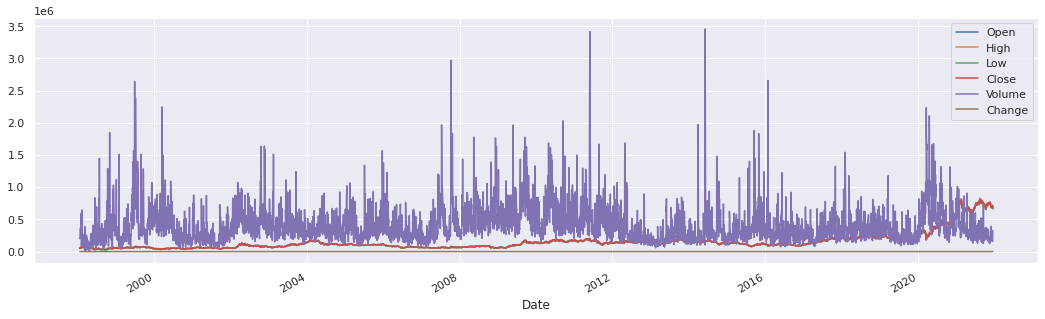

In [ ]:
stock_p.plot()

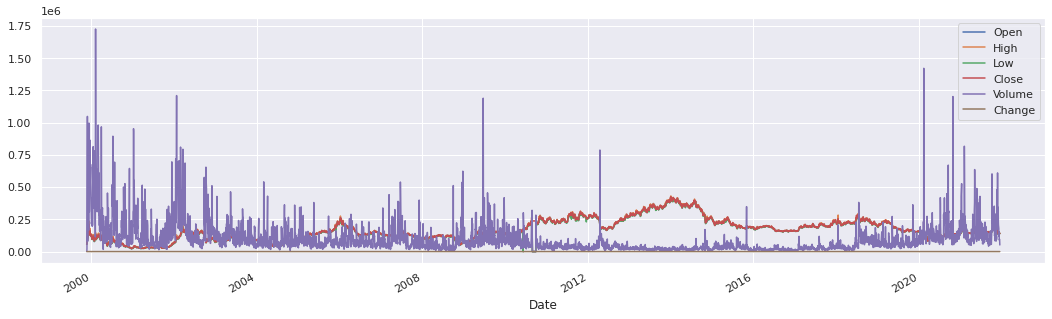

In [ ]:
stock_q.plot()

## 2.2 Pre-processing & engineering

In [ ]:
def target_split(df, shift_size = 1, target = 'Close'):
    X = df.drop(target, axis=1)
    y = df[target]
    y = y.shift(shift_size)
    return X.iloc[shift_size:,:], y.iloc[shift_size:]

In [ ]:
X_p, y_p = target_split(stock_p, shift_size = 1)
X_q, y_q = target_split(stock_q, shift_size = 1)

In [ ]:
X_p.info(), X_q.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5945 entries, 1998-01-23 to 2021-12-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5945 non-null   int64  
 1   High    5945 non-null   int64  
 2   Low     5945 non-null   int64  
 3   Volume  5945 non-null   int64  
 4   Change  5945 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 278.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5446 entries, 1999-11-24 to 2021-12-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5446 non-null   int64  
 1   High    5446 non-null   int64  
 2   Low     5446 non-null   int64  
 3   Volume  5446 non-null   int64  
 4   Change  5446 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 255.3 KB


(None, None)

In [ ]:
y_p.isna().sum(), y_q.isna().sum()

(0, 0)

In [ ]:
temp_list = ['p', 'q']

for idx in temp_list:
    globals()[f'mme_{idx}1'] = MinMaxScaler() # ex. mme_p1 = MinMaxScaler()
    globals()[f'mme_{idx}2'] = MinMaxScaler() # ex. mme_p2 = MinMaxScaler()

    temp = globals()[f'X_{idx}']
    globals()[f'X_{idx}2'] = globals()[f'mme_{idx}1'].fit_transform(temp) # ex. X_p = mme_p1(X_p)

    temp = globals()[f'y_{idx}'].values.reshape(-1,1)
    globals()[f'y_{idx}2'] = globals()[f'mme_{idx}2'].fit_transform(temp) # ex. y_p = mme_p2(y_p.values.reshape(-1,1))

In [ ]:
X_p = pd.DataFrame(X_p2, columns = X_p.columns, index = X_p.index)
y_p = pd.DataFrame(y_p2, columns = [y_p.name], index = y_p.index)
X_q = pd.DataFrame(X_q2, columns = X_q.columns, index = X_q.index)
y_q = pd.DataFrame(y_q2, columns = [y_q.name], index = y_q.index)

In [ ]:
def window_data(X, y, window_size = 20):
    X = X.fillna(method = 'bfill')

    X_list = []
    y_list = []

    for i in range(len(X) - window_size):
        X_train=X.iloc[i : i+window_size, :]
        y_train=y.iloc[i+window_size]
        X_list.append(X_train)
        y_list.append(y_train)

    return np.array(X_list), np.array(y_list)

In [ ]:
X_p_train, y_p_train = window_data(X_p, y_p, window_size = 20)
print(X_p_train.shape, y_p_train.shape)


X_q_train, y_q_train = window_data(X_q, y_q, window_size = 20)
print(X_q_train.shape, y_q_train.shape)

(5925, 20, 5) (5925, 1)
(5426, 20, 5) (5426, 1)


In [ ]:
def val_split(X_train, y_train, split_ratio=0.2):
    if X_train.shape[0]!=y_train.shape[0]:
        print('error!!!')

    else:
        val_size = int(X_train.shape[0]*split_ratio)
        
        X_val = X_train[-val_size:]
        X_train = X_train[:-val_size]

        y_val = y_train[-val_size:]
        y_train = y_train[:-val_size]

        print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

        return X_train, X_val, y_train, y_val


In [ ]:
X_p_train, X_p_val, y_p_train, y_p_val = val_split(X_p_train, y_p_train)

(4740, 20, 5) (1185, 20, 5) (4740, 1) (1185, 1)


In [ ]:
# many_to_one

lstm= LSTM(units =16, # 내보내는 개수
               input_shape = (X_p_train.shape[1:]),
                activation = 'tanh',
                recurrent_activation = 'sigmoid',
                dropout=0.0,
                recurrent_dropout = 0.0,
                return_sequences=False) # sequence내뱉는 걸 다음 놈한테 줄 거냐 말 거냐. True(many to many)는 뒷레이어한테도 준다. False면 옆 놈한테만 준다.(many to one)

model = Sequential()
model.add(lstm)

model.add(Dense(1, ))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 16)                1408      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
import shutil

if os.path.exists("/content/gdrive/MyDrive/stock_price_d/models"):
    shutil.rmtree("/content/gdrive/MyDrive/stock_price_d/models") 

if not os.path.exists("/content/gdrive/MyDrive/stock_price_d/models"):
    os.mkdir('/content/gdrive/MyDrive/stock_price_d/models')  


In [ ]:
model.compile(loss="mae", optimizer='adam')# , metrics="mae")

stop = EarlyStopping(patience=10, monitor='val_loss')

check_point = ModelCheckpoint(filepath='/content/gdrive/MyDrive/stock_price_d/models/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',          #------------어떤 점수를 기준으로 모니터링할까
                    save_best_only=True,         #------------이전보다 좋아질때만 저장
                    save_weights_only=False      #------------모델+가중치 같이 저장
                   ) 
res = model.fit(X_p_train, y_p_train, 
          callbacks=[stop, check_point],
          epochs = 100,
          batch_size = 32,
          validation_split=0.2
         )

Epoch 1/100
119/119 [==============================] - 4s 16ms/step - loss: 0.0220 - val_loss: 0.0063
Epoch 2/100
119/119 [==============================] - 2s 13ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 3/100
119/119 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/100
119/119 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/100
119/119 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/100
119/119 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/100
119/119 [==============================] - 2s 13ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
119/119 [==============================] - 2s 13ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
119/119 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/100
119/119 [==============================] - 2s 13ms/step - loss: 0.001

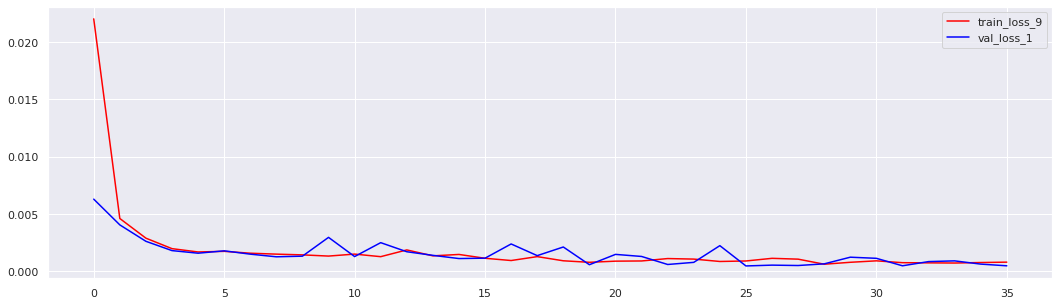

In [ ]:
plt.plot(np.arange(len(res.history['val_loss'])), res.history['loss'], c='red', label='train_loss_9')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss_1')
plt.legend()
plt.show()


In [ ]:
pred = model.predict(X_p_val)
print(pred.shape, y_p_val.shape)

(1185, 1) (1185, 1)


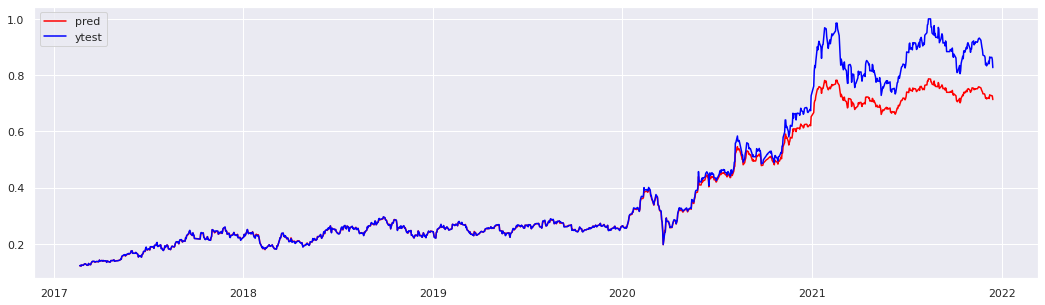

In [ ]:
plt.plot(X_p.index[-X_p_val.shape[0]:], pred, c='red', label='pred')
plt.plot(X_p.index[-X_p_val.shape[0]:], y_p_val, c='blue', label='ytest')
plt.legend()
plt.show()

In [ ]:
pred_orig   = mme_p2.inverse_transform(pred)
y_p_val_orig   = mme_p2.inverse_transform(y_p_val)
print(pred_orig[:5])

[[123503.734]
 [123190.336]
 [124521.26 ]
 [122973.15 ]
 [125453.01 ]]


In [ ]:
np.sum(abs(pred_orig-y_p_val_orig))*pred_orig.shape[0]/np.sum(y_p_val_orig)

84.00410447947971

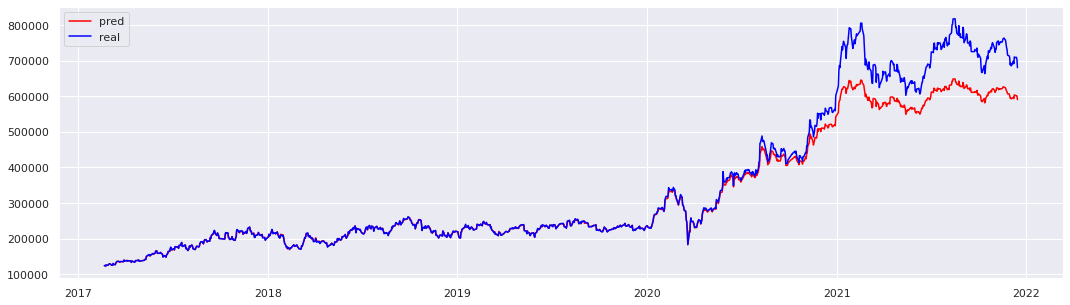

In [ ]:
plt.plot(X_p.index[-X_p_val.shape[0]:], pred_orig, c='red', label='pred')
plt.plot(X_p.index[-X_p_val.shape[0]:], y_p_val_orig, c='blue', label='real')
plt.legend()
plt.show()


# 전체 데이터에 대해 모델 돌리기
<방법>
1. 모든 개별 회사에 대해 fit
2. 산업별 대표격 되는 회사에 대해 fit 하고 weight 사용해서 나머지 빨리 돌림(근데 금방 돌아가는데 모델이 안 딥해서)ㅡ

In [ ]:
############################################################

### 1.6.1 VIX 

In [ ]:
vix = fdr.DataReader('VIX', '1990-01-01', '2021-12-15')

In [ ]:
vix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8055 entries, 1990-01-03 to 2021-12-15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8055 non-null   float64
 1   Open    8055 non-null   float64
 2   High    8055 non-null   float64
 3   Low     8055 non-null   float64
 4   Volume  8055 non-null   float64
 5   Change  8055 non-null   float64
dtypes: float64(6)
memory usage: 440.5 KB


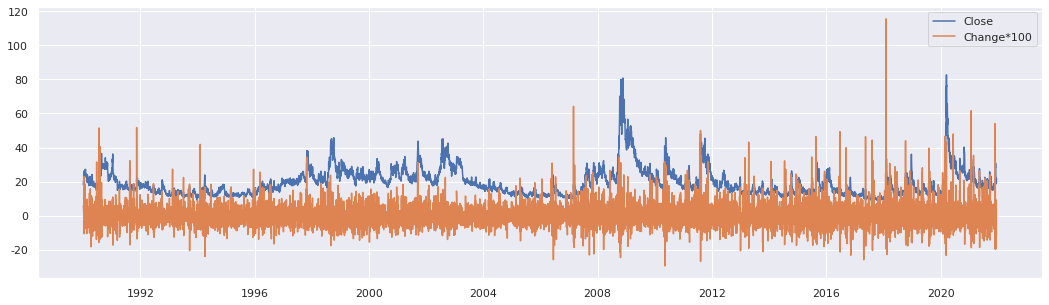

In [ ]:
plt.plot(vix['Close'], label='Close')
plt.plot(vix['Change']*100, label='Change*100')
plt.legend()
plt.show()

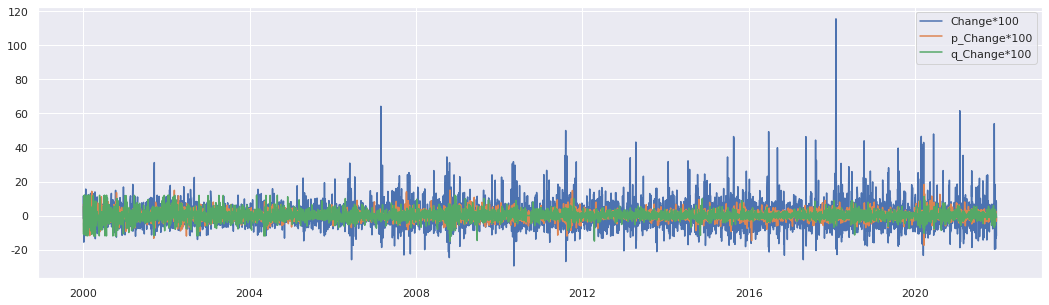

In [ ]:
start_date='2000-01-01'
end_date='2021-12-15'

# plt.plot(vix[(start_date <= vix.index) & (vix.index <= end_date)]['Close'], label='Close')
plt.plot(vix[(start_date <= vix.index) & (vix.index <= end_date)]['Change']*100, label='Change*100')
# plt.plot(stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)]['Close'], label='Close_p')
plt.plot(stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)]['Change']*100, label='p_Change*100')
# plt.plot(stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)]['Close'], label='Close_q')
plt.plot(stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)]['Change']*100, label='q_Change*100')


plt.legend()
plt.show()

In [ ]:
temp1 = vix[(start_date <= vix.index) & (vix.index <= end_date)][['Change', 'Close']]
temp2 = stock_p[(start_date <= stock_p.index) & (stock_p.index <= end_date)][['Change', 'Close']]
temp3 = stock_q[(start_date <= stock_q.index) & (stock_q.index <= end_date)][['Change', 'Close']]

temp = pd.concat([temp1, temp2, temp3], axis=1)

In [ ]:
temp.columns=['Change_vix', 'Close_vix', 'Change_p', 'Close_p', 'Change_q', 'Close_q']

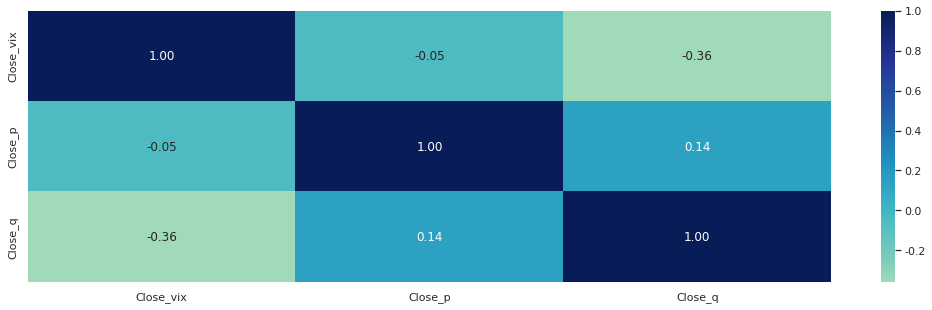

In [ ]:
temp_list = [col for col in temp.columns if 'Close' in col]
sns.heatmap(temp[temp_list].corr(), annot=True, fmt=".2f", center=0, cmap='YlGnBu')

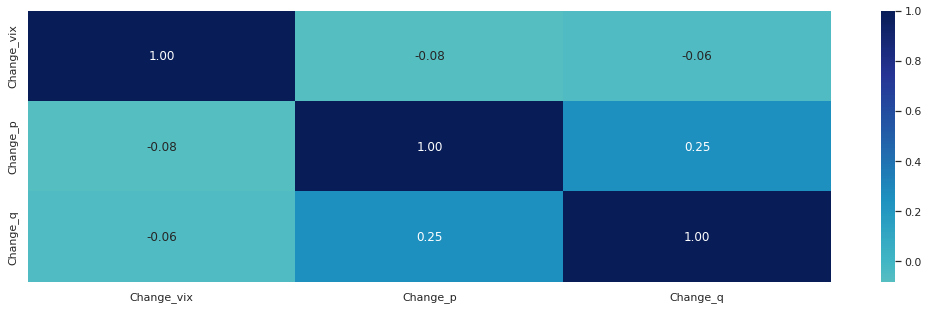

In [ ]:
temp_list = [col for col in temp.columns if 'Change' in col]
sns.heatmap(temp[temp_list].corr(), annot=True, fmt=".2f", center=0, cmap='YlGnBu')

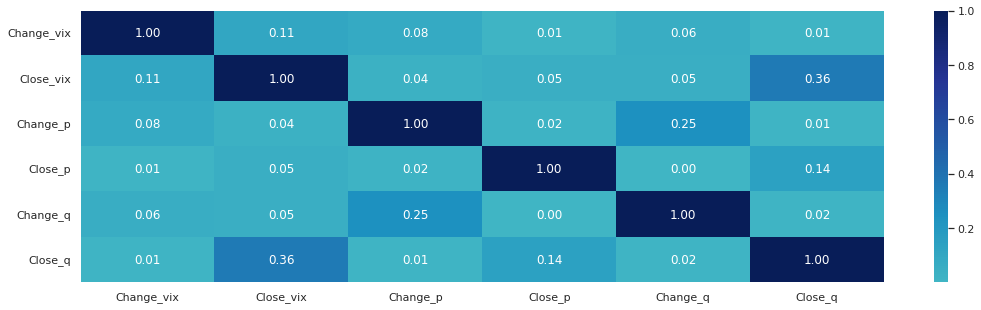

In [ ]:
sns.heatmap(abs(temp.corr()), annot=True, fmt=".2f", center=0, cmap='YlGnBu')